# Chapter 7. Model assessment and selection

## 7.10: Cross-Validation

In [94]:
# Import dependent packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
import scipy as sp
from scipy import linalg
plt.style.use('seaborn')
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from IPython.display import Image
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.ensemble import BaggingRegressor
import warnings
warnings.filterwarnings("ignore")


In [2]:
### Function takes two feature transform methods: normalization and MiniMaxScale
def feature_prerpocess(data, form = 'normal'):
    if form == "normal":
        new_data = scale(data)
    elif form == "MinMax":
        new_data = minmax_scale(data)
    return pd.DataFrame(new_data)

One of the simplest and most widely used method for estimating predicton error is cross-validation. This method directly estimates expected test error $Err=E[E(L(Y,\hat{f(x)})|\tau)]$, which is the average generalization error over independent test sets.

### 7.10.1 K-fold Cross-Validation

In K-fold cross-validation we split the data into $K$ roughly equal-sied parts, for example when $K=5$:

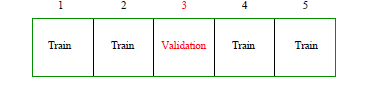

In [115]:
Image(filename='CV.png', width=800,  height =100) 

For the $k^{th}$ part (thired above), we fit the model to the other $K-1$ parts of the data, and calculate the prediction error of the fitted model for $k^{th}$ part.

\begin{equation}
CV(\hat{f}) = \frac{1}{N}\sum_{i=1}^{N} L(y_i, \hat{f}^{-k(i)}(x_i))
\end{equation}

where $\hat{f}^{-k(i)}$ is the fitted function, computed with the $k^{th}$ part of the data removed. 


When $K=N$, it is leave-one-out cross-validation. In this case $k(i)=i$, and for the $i^{th}$ observation the fit is computed using all the data except the $i^{th}$


We will use "Seoul Bike" dataset, it can can be downloaded:
* <a href="https://www.kaggle.com/c/seoul-bike-rental-prediction/data">Seoul Bike Rental Prediction
    
The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information. The target variable is a bike count required at each hour.

In [4]:
#Download data 
Seoul_bike = pd.read_csv('SeoulBikeData.csv', sep=',', encoding= 'unicode_escape')
Seoul_bike

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


As we can see there are one date, three categorical and ten continous/integer variables and 8760 observations. For simplicity I dropped date variable, as time series data requires some additional approaches in building a model.
The dependent variable is the number of bikes rented per hour.

In [5]:
X_matrix = Seoul_bike.iloc[:100, 2:10]
X_matrix

,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm)
0,0,-5.2,37,2.2,2000,-17.6,0.0,0.0
1,1,-5.5,38,0.8,2000,-17.6,0.0,0.0
2,2,-6.0,39,1.0,2000,-17.7,0.0,0.0
3,3,-6.2,40,0.9,2000,-17.6,0.0,0.0
4,4,-6.0,36,2.3,2000,-18.6,0.0,0.0
...,...,...,...,...,...,...,...,...
95,23,-5.8,44,2.4,2000,-16.1,0.0,0.0
96,0,-6.1,42,2.6,2000,-16.9,0.0,0.0
97,1,-6.5,41,2.8,2000,-17.6,0.0,0.0
98,2,-6.8,41,2.5,2000,-17.8,0.0,0.0


In [6]:
y_var = Seoul_bike.iloc[:100, 1:2]
y_var

,Rented Bike Count
0,254
1,204
2,173
3,107
4,78
...,...
95,248
96,216
97,198
98,124


In [7]:
# Scale the data
X_matrix = feature_prerpocess(X_matrix, form = 'normal')
y_var = feature_prerpocess(y_var, form = 'normal')

We compare the following models using K-fold CV:
1. Linear regression,
2. Support Vector Machines,
3. Random Forest,
4. K-nn

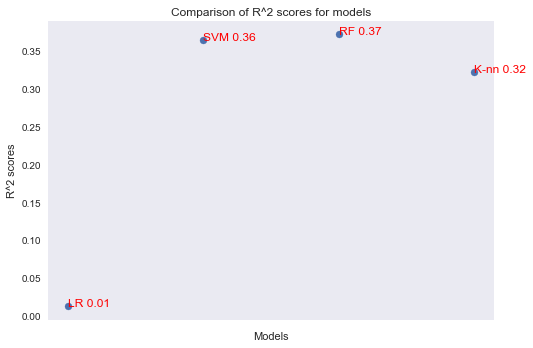

In [96]:
# models
models = [linear_model.LinearRegression(),
                    svm.SVR(), RandomForestRegressor(max_depth=3, random_state=0), neighbors.KNeighborsRegressor(5)]

def CV_scores(X, y, models, n_split):
    scores = []
    CV = KFold(n_splits=n_split, random_state=1, shuffle=True)
    np.set_printoptions(formatter={'float_kind':'{:f}'.format})
    for i in models:
        scores.append(np.mean(cross_val_score(i, X=X, y=y, scoring='r2', cv=CV, n_jobs=-1)))
    return np.array(scores)

model_cv=[1,2,3,4]
scores = CV_scores(X_matrix, y_var, models, n_split=10)

fig, ax = plt.subplots()
ax.scatter(model_cv, scores)

ax.set(xlabel='Models', ylabel='R^2 scores',
       title='Comparison of R^2 scores for models')
ax.set_xticklabels([])
plt.text(1,scores[0],'LR'+ " " + str(np.around(scores[0],2)), fontsize=12, c="red")
plt.text(2,scores[1],'SVM'+ " " + str(np.around(scores[1],2)), fontsize=12, c="red")
plt.text(3,scores[2],'RF'+ " " + str(np.around(scores[2],2)), fontsize=12, c="red")
plt.text(4,scores[3],'K-nn'+ " " + str(np.around(scores[3],2)), fontsize=12, c="red")

ax.grid()
plt.show()

## 7.11 Bootstrap methods

The bootstrap is a general tool for assessing statistical accuracy. The bootstrap is a random sample of the data taken with replacement. The bootstrap can be used to estimate prediction error:

\begin{equation}
\hat{Err_{boot}} = \frac{1}{B} \frac{1}{N} \sum_{b=1}^{B} \sum_{i=1}^{N} L(y_i, \hat{f}^{b}(x_i))
\end{equation}

where, $\hat{f}^{b}(x_i)$ is the predicted value at $x_i$ from the model fitted to the $b^{th}$ bootrsap dataset.

The boostrap can be implemented using $BaggingRegressor$ function from sklearn package.

We compare the following models using the Bootstrap:
1. Linear regression,
2. Support Vector Machines,
3. Random Forest,
4. K-nn

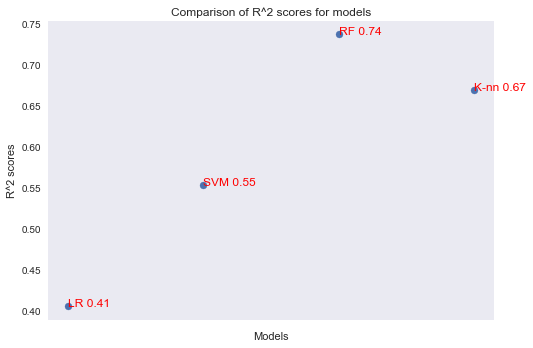

In [109]:
# models
models = [linear_model.LinearRegression(),
                    svm.SVR(), RandomForestRegressor(max_depth=3, random_state=0), neighbors.KNeighborsRegressor(5)]

def Bootstrap_scores(X, y, models, n_estimators):
    scores = []
    np.set_printoptions(formatter={'float_kind':'{:f}'.format}, precision=1)
    for i in models:
        scores.append(BaggingRegressor(base_estimator=i, n_estimators=n_estimators, random_state=0).fit(X, y).score(X, y))
    return np.array(scores)

model_cv=[1,2,3,4]
scores = Bootstrap_scores(X_matrix, y_var, models, n_estimators=10)

fig, ax = plt.subplots()
ax.scatter(model_cv, scores)

ax.set(xlabel='Models', ylabel='R^2 scores',
       title='Comparison of R^2 scores for models')
ax.set_xticklabels([])
plt.text(1,scores[0],'LR'+ " " + str(np.around(scores[0],2)), fontsize=12, c="red")
plt.text(2,scores[1],'SVM'+ " " + str(np.around(scores[1],2)), fontsize=12, c="red")
plt.text(3,scores[2],'RF'+ " " + str(np.around(scores[2],2)), fontsize=12, c="red")
plt.text(4,scores[3],'K-nn'+ " " + str(np.around(scores[3],2)), fontsize=12, c="red")

ax.grid()
plt.show()

A better bootstrap estimate can be obtained by mimicking cross-validation. For each observation,  we only keep track of predictions from bootstrap samples not containing that observation.

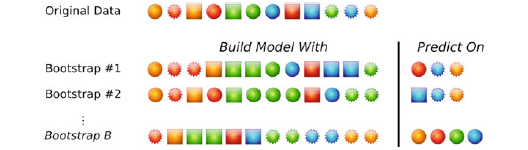

In [116]:
Image(filename='bootstrap.png', width=600,  height =100) 

The $leave-one-out$ bootstrap estimate of prediction error is defined by

\begin{equation}
\hat{Err_{boot}} = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|C^{-i}|} \sum_{b \in C^{-i}}^{} L(y_i, \hat{f}^{b}(x_i))
\end{equation}

where $C^{-i}$ is the of indices of the bootstrap samples $b$ that do not contain observation $i$, and $|C^{-i}|$ is the number of such samples.

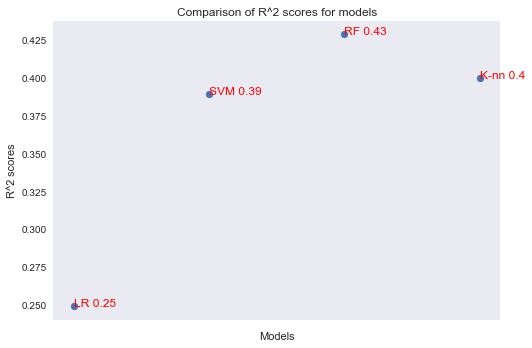

In [110]:
# models
models = [linear_model.LinearRegression(),
                    svm.SVR(), RandomForestRegressor(max_depth=3, random_state=0), neighbors.KNeighborsRegressor(5)]

def Bootstrap_scores(X, y, models, n_estimators):
    scores = []
    np.set_printoptions(formatter={'float_kind':'{:f}'.format}, precision=1)
    for i in models:
        scores.append(BaggingRegressor(base_estimator=i, n_estimators=n_estimators, random_state=0, oob_score=True).fit(X, y).oob_score_)
    return np.array(scores)

model_cv=[1,2,3,4]
scores = Bootstrap_scores(X_matrix, y_var, models, n_estimators=10)

fig, ax = plt.subplots()
ax.scatter(model_cv, scores)

ax.set(xlabel='Models', ylabel='R^2 scores',
       title='Comparison of R^2 scores for models')
ax.set_xticklabels([])
plt.text(1,scores[0],'LR'+ " " + str(np.around(scores[0],2)), fontsize=12, c="red")
plt.text(2,scores[1],'SVM'+ " " + str(np.around(scores[1],2)), fontsize=12, c="red")
plt.text(3,scores[2],'RF'+ " " + str(np.around(scores[2],2)), fontsize=12, c="red")
plt.text(4,scores[3],'K-nn'+ " " + str(np.around(scores[3],2)), fontsize=12, c="red")

ax.grid()
plt.show()